In [1]:
import muon
import re
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import celltypist
from celltypist import models
import os
os.chdir("C:\\Users\\dan94\\OneDrive - University College London\\UCL_Senior_Research_Fellow\\RIPs_Vincent_project\\samples")
os.listdir()
os.environ["R_HOME"] = "C:\\Users\\dan94\\miniconda3\\envs\\scrnaseq\\Lib\\R\\"
import rpy2
import anndata2ri #has to be version 1.1 to not throw error, so check this is the case
from rpy2.robjects import r
anndata2ri.activate()
%load_ext rpy2.ipython

cffi mode is CFFI_MODE.ANY
R home found: C:\Users\dan94\miniconda3\envs\scrnaseq\Lib\R\
Default options to initialize R: rpy2, --quiet, --no-save


In [2]:
import decoupler as dc

In [5]:
sepsis = sc.read(filename = "myeloid_integrated.h5ad")

In [4]:
sepsis

AnnData object with n_obs × n_vars = 37671 × 46623
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'source', 'condition', 'donor_id', 'percent.mt', 'unintegrated_clusters', 'seurat_clusters', 'clusters', 'condition2', 'clusters_0.3', 'clusters_0.4', 'clusters_0.5', 'clusters_0.6', 'clusters_0.7', 'clusters_0.8', 'clusters_0.9', 'clusters_1.0', 'labels', 'RIP_genes1', 'status', 'sepsis_state', 'ident'
    uns: 'X_name'
    obsm: 'HARMONY', 'INTEGRATED.SCVI', 'PCA', 'UMAP.HARMONY', 'UMAP.SCVI', 'UMAP.UNINTEGRATED'
    layers: 'counts_layer', 'logcounts'

In [6]:
sepsis.X = sepsis.layers["counts_layer"]

In [ ]:
#adding in neighbor grahh from seurat
import scipy.io
# Load graph
graph = scipy.io.mmread("snn_graph.mtx").tocsr()

# Load cell names
cell_names = pd.read_csv("cell_names.csv")["x"]

# Reorder AnnData to match
sepsis = sepsis[cell_names.values].copy()

# Assign to `.obsp` (standard place for graphs)
sepsis.obsp["connectivities"] = graph


In [165]:
sepsis.uns["neighbors"] = {
    "connectivities_key": "connectivities",
    "params": {
        "n_neighbors": 20,  # set this to what Seurat used
        "method": "custom",
        "metric": "euclidean"
    }
}

In [8]:
sepsis_only = sepsis[sepsis.obs['condition2'].isin(['Sepsis', 'HC'])].copy()

In [9]:
sepsis_only

AnnData object with n_obs × n_vars = 37671 × 46623
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'source', 'condition', 'donor_id', 'percent.mt', 'unintegrated_clusters', 'seurat_clusters', 'clusters', 'condition2', 'clusters_0.3', 'clusters_0.4', 'clusters_0.5', 'clusters_0.6', 'clusters_0.7', 'clusters_0.8', 'clusters_0.9', 'clusters_1.0', 'labels', 'RIP_genes1', 'status', 'sepsis_state', 'ident'
    uns: 'X_name'
    obsm: 'HARMONY', 'INTEGRATED.SCVI', 'PCA', 'UMAP.HARMONY', 'UMAP.SCVI', 'UMAP.UNINTEGRATED'
    layers: 'counts_layer', 'logcounts'

In [159]:
#small detour into running celltypist on the myeloid cells to figure out what they are
#Setting majority voting result as the cell label, 
# the predicted label (for each cell, without clustering majority voting) will be the 'predict'
def join_celltypist_df(celltypist_adata_obs, 
                       input_adata_obs, 
                       new_col_suffix):
    """Join relevant columns of the celltypist dataframe with the adata.obs input"""
    import pandas as pd
    celltypist_df = pd.DataFrame({"celltypist_label_" + new_col_suffix : celltypist_adata_obs["majority_voting"],
                                 "celltypist_predict_" + new_col_suffix : celltypist_adata_obs["predicted_labels"],
                                 "celltypist_conf_score_" + new_col_suffix : celltypist_adata_obs["conf_score"]})
    return input_adata_obs.join(celltypist_df)

In [160]:
models.download_models(
    force_update=True, 
    model=["Immune_All_Low.pkl",
           "Immune_All_High.pkl"]
)
model_low = models.Model.load(model="Immune_All_Low.pkl")
model_high = models.Model.load(model="Immune_All_High.pkl")

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in C:\Users\dan94\.celltypist\data\models
💾 Total models to download: 2
💾 Downloading model [1/2]: Immune_All_Low.pkl
💾 Downloading model [2/2]: Immune_All_High.pkl


In [ ]:
adata_celltypist = sepsis_only.copy()  # make a copy of our adata

# if(testing):
#     adata_celltypist.X = adata_concat.X 
# else:
adata_celltypist.X = sepsis_only.layers["counts_layer"]

sc.pp.normalize_per_cell(
    adata_celltypist, counts_per_cell_after=10**4
)  # normalize to 10,000 counts per cell
# np.apply_along_axis(sum, axis = 1, arr = adata_celltypist.X
sc.pp.log1p(adata_celltypist)  # log-transform
# make .X dense instead of sparse, for compatibility with celltypist:
adata_celltypist.X = adata_celltypist.X.toarray()

In [ ]:
predictions_low = celltypist.annotate(
    adata_celltypist, model=model_low, majority_voting=True
)
predictions_low_adata = predictions_low.to_adata()
sepsis_only.obs = join_celltypist_df(predictions_low_adata.obs, 
                                      sepsis_only.obs, 
                                      "immune_fine")

In [175]:
sepsis_only

AnnData object with n_obs × n_vars = 37492 × 46623
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'source', 'condition', 'donor_id', 'percent.mt', 'unintegrated_clusters', 'seurat_clusters', 'clusters', 'condition2', 'clusters_0.3', 'clusters_0.4', 'clusters_0.5', 'clusters_0.6', 'clusters_0.7', 'clusters_0.8', 'clusters_0.9', 'clusters_1.0', 'labels', 'RIP_genes1', 'status', 'ident', 'celltypist_label_immune_fine', 'celltypist_predict_immune_fine', 'celltypist_conf_score_immune_fine'
    uns: 'X_name', 'neighbors', 'celltypist_label_immune_fine_colors'
    obsm: 'HARMONY', 'PCA', 'UMAP.HARMONY', 'UMAP.UNINTEGRATED'
    layers: 'counts_layer', 'logcounts'
    obsp: 'connectivities'

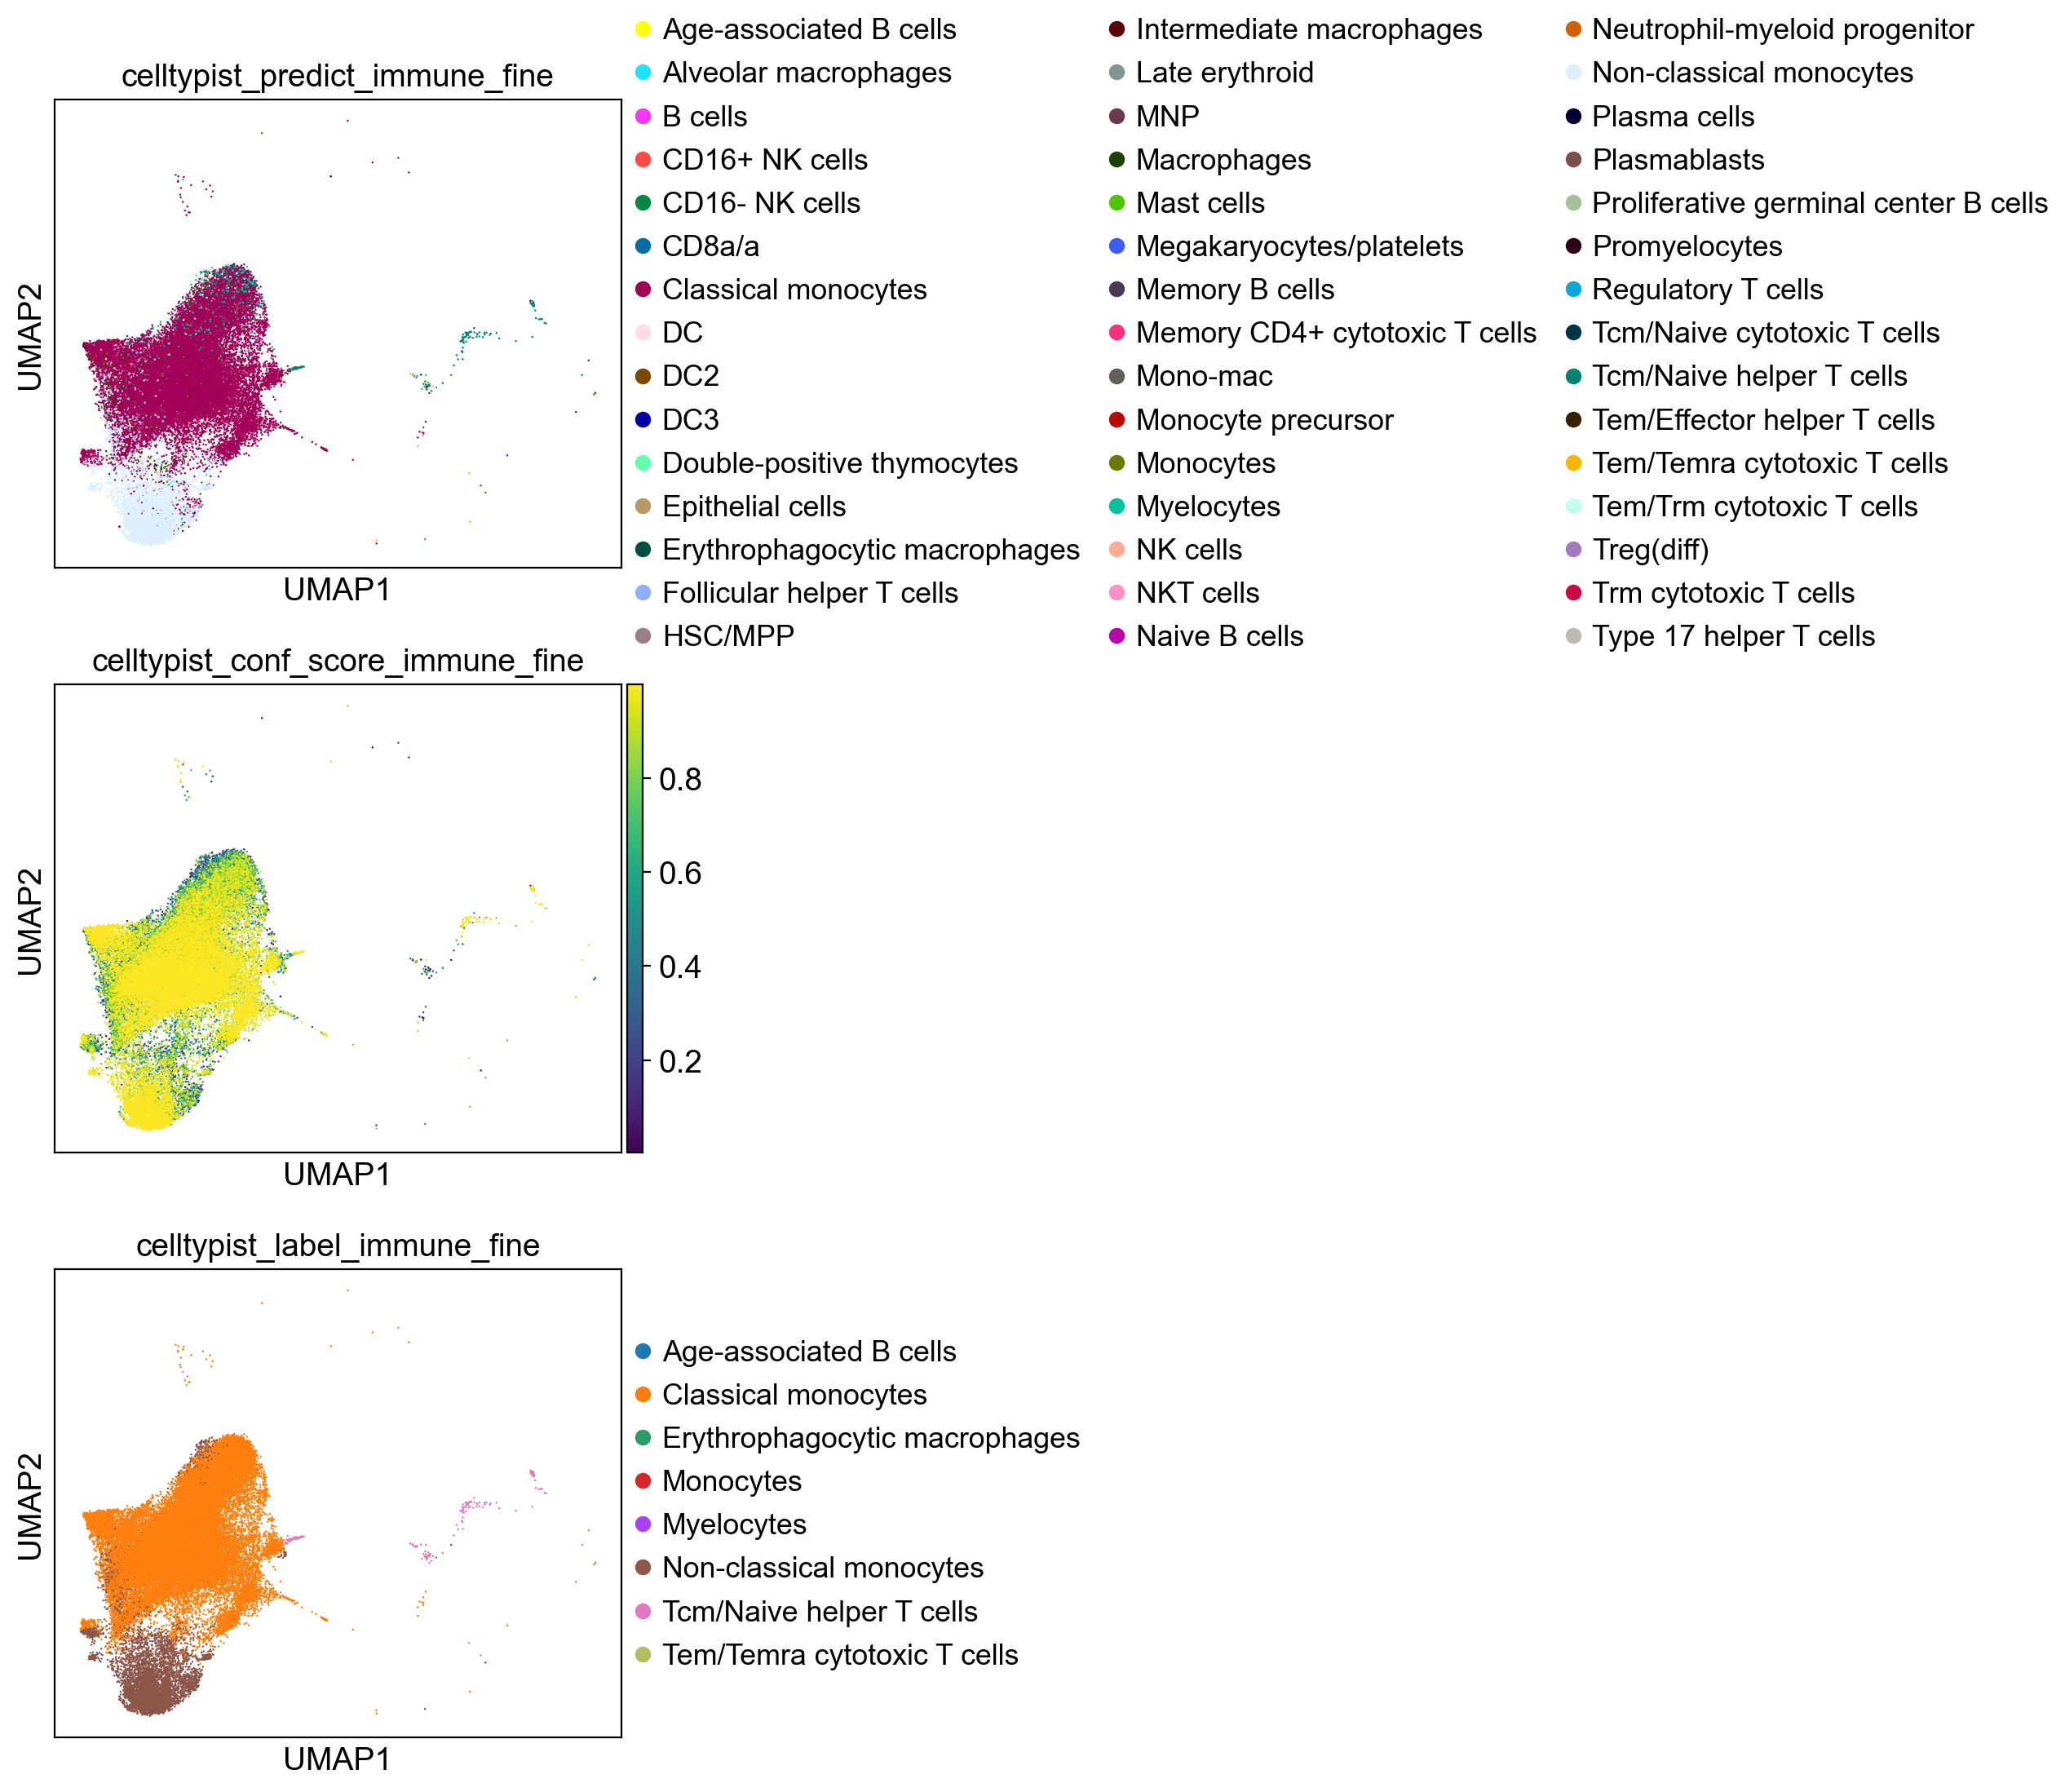

In [180]:
sepsis_only.obsm["X_umap"] = sepsis_only.obsm["UMAP.HARMONY"].values
sc.pl.umap(sepsis_only, color=["celltypist_predict_immune_fine", "celltypist_conf_score_immune_fine",
                              "celltypist_label_immune_fine"], ncols=1)

In [10]:
#pseudobulking samples
psepsis = dc.pp.pseudobulk(adata = sepsis_only, sample_col = "donor_id", groups_col = "labels", mode="sum")

In [11]:
psepsis

AnnData object with n_obs × n_vars = 260 × 46623
    obs: 'donor_id', 'labels', 'orig.ident', 'sample', 'source', 'condition', 'condition2', 'status', 'sepsis_state', 'ident', 'psbulk_cells', 'psbulk_counts'
    layers: 'psbulk_props'

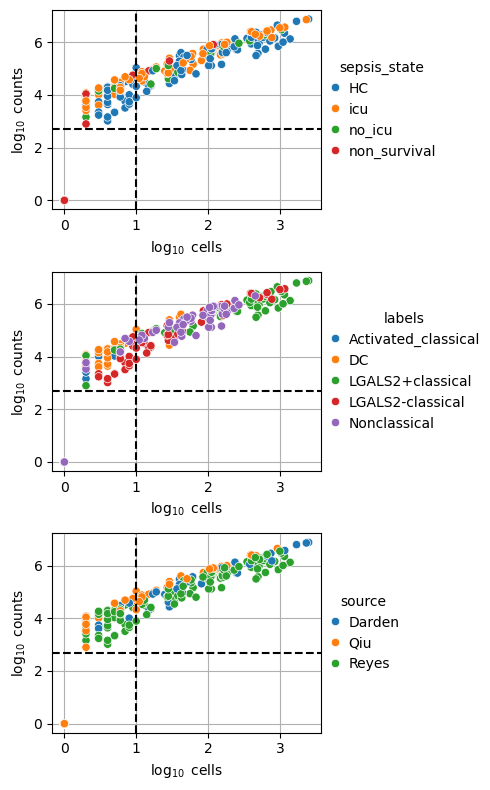

In [12]:
dc.pl.filter_samples(
    adata=psepsis,
    groupby=['sepsis_state', 'labels', "source"],
    min_cells=10,
    min_counts=500,
    figsize=(5, 8),
)

In [13]:
dc.pp.filter_samples(psepsis, min_cells=10, min_counts=500)

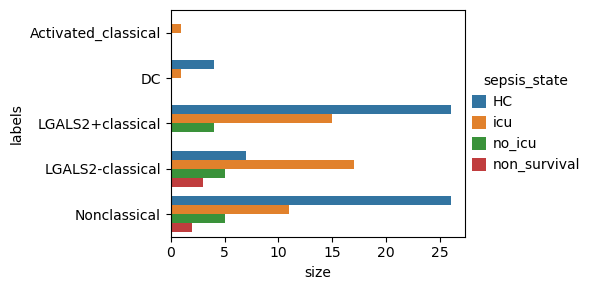

In [14]:
dc.pl.obsbar(
    adata=psepsis,
    y='labels',
    hue='sepsis_state',
    figsize=(6, 3)
)

In [54]:
LGALS2pos_classical = psepsis[psepsis.obs['labels'] == 'LGALS2+classical'].copy()
LGALS2neg_classical = psepsis[psepsis.obs['labels'] == 'LGALS2-classical'].copy()
nonclassical = psepsis[psepsis.obs['labels'] == 'Nonclassical'].copy()

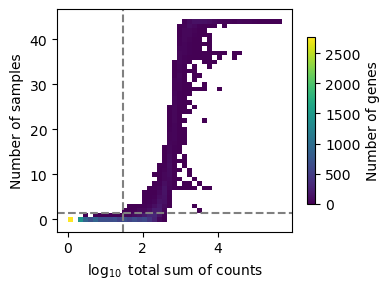

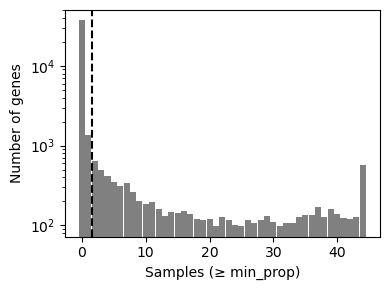

In [91]:
#note- .pl in the function is telling it to plot
#in the next step once we've decided on thresholds, we will use .pp
dc.pl.filter_by_expr(
    adata=nonclassical,
    group='sepsis_state',
    min_count=10,
    min_total_count=30,
    large_n=10,
    min_prop=0.5,
)
dc.pl.filter_by_prop(
    adata=nonclassical,
    min_prop=0.1,
    min_smpls=2,
)

In [92]:
dc.pp.filter_by_expr(
    adata=nonclassical,
    group='sepsis_state',
    min_count=10,
    min_total_count=30,
    large_n=10,
    min_prop=0.5,
)
dc.pp.filter_by_prop(
    adata=nonclassical,
    min_prop=0.1,
    min_smpls=2,
)
nonclassical

AnnData object with n_obs × n_vars = 44 × 6106
    obs: 'donor_id', 'labels', 'orig.ident', 'sample', 'source', 'condition', 'condition2', 'status', 'sepsis_state', 'ident', 'psbulk_cells', 'psbulk_counts'
    layers: 'psbulk_props'

In [158]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=nonclassical,
    design="~ source + sepsis_state",
    refit_cooks=True,
    inference=inference,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between conditions
stat_res = DeseqStats(
    dds,
    contrast=["sepsis_state", "no_icu", "HC"],
    inference=inference
)

# Compute Wald test
stat_res.summary()

Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 4.37 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 3.94 seconds.

Fitting LFCs...
... done in 2.76 seconds.

Calculating cook's distance...
... done in 0.08 seconds.

Replacing 23 outlier genes.

Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.09 seconds.

Running Wald tests...
... done in 1.25 seconds.



Log2 fold change & Wald test p-value: sepsis_state no_icu vs HC
          baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
HMGCL     4.754829        0.193580  0.309174  0.626119  0.531237       NaN
RAMMET    2.951779       -0.401702  2.482894 -0.161788  0.871473       NaN
ANAPC13  12.628576        0.320303  0.240757  1.330403  0.183386  0.836335
H1FX     53.100066       -0.634849  0.269918 -2.352007  0.018672  0.414345
ASGR1    15.352883        0.136554  0.261327  0.522542  0.601293  0.959668
...            ...             ...       ...       ...       ...       ...
TMEM123  27.116844        0.162585  0.203569  0.798674  0.424479  0.931392
HIBADH    3.700635       -0.378198  0.382215 -0.989491  0.322423       NaN
COQ4      6.956273        0.259052  0.281308  0.920882  0.357112  0.913589
ANAPC11  50.102458        0.158995  0.131142  1.212384  0.225365  0.862387
TAF13     3.280213        0.327143  0.513413  0.637194  0.523998       NaN

[6106 rows x 6 columns]


In [159]:
# Extract results
results_df = stat_res.results_df
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
HMGCL,4.754829,0.193580,0.309174,0.626119,0.531237,NaN
RAMMET,2.951779,-0.401702,2.482894,-0.161788,0.871473,NaN
ANAPC13,12.628576,0.320303,0.240757,1.330403,0.183386,0.836335
H1FX,53.100066,-0.634849,0.269918,-2.352007,0.018672,0.414345
ASGR1,15.352883,0.136554,0.261327,0.522542,0.601293,0.959668
...,...,...,...,...,...,...
TMEM123,27.116844,0.162585,0.203569,0.798674,0.424479,0.931392
HIBADH,3.700635,-0.378198,0.382215,-0.989491,0.322423,NaN
COQ4,6.956273,0.259052,0.281308,0.920882,0.357112,0.913589
ANAPC11,50.102458,0.158995,0.131142,1.212384,0.225365,0.862387


In [160]:
results_df.to_csv("deseq2_nonclassical_no_icu_vs_HC_all_genes.csv", index = True)

In [151]:
#just making a table of significant genes to inspect - not needed for anything else
sig_res = results_df[results_df["padj"] < 0.05]

In [152]:
sig_res.to_csv("deseq2_nonclassical_non_survival_vs_HC.csv", index = True)

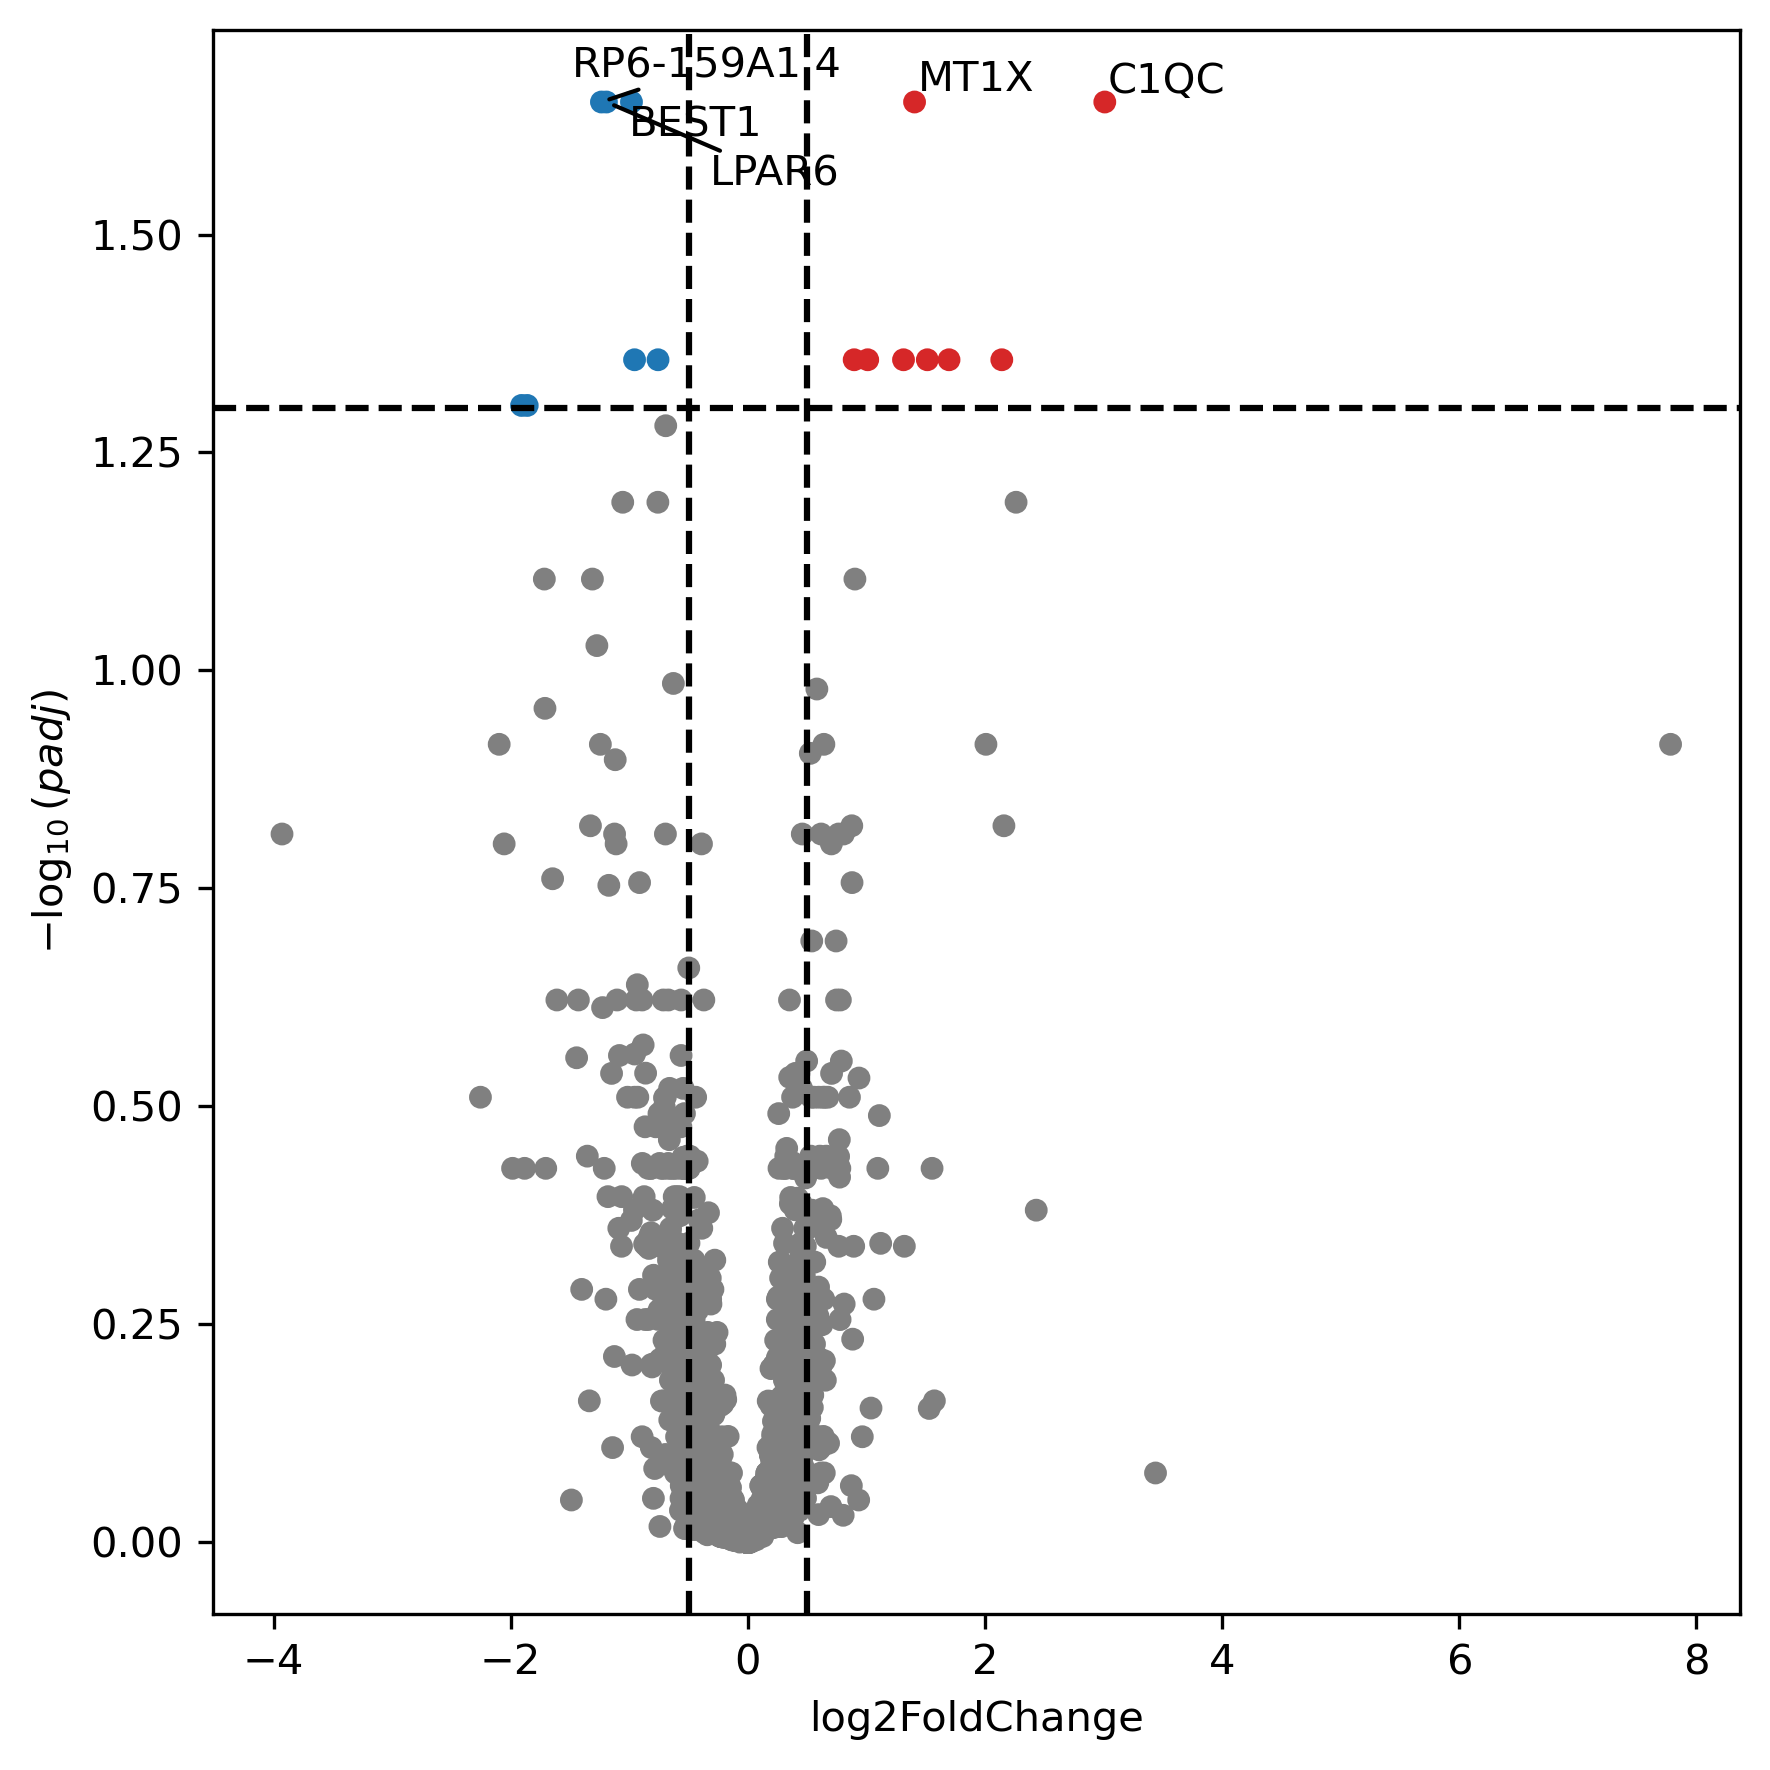

In [161]:
dc.pl.volcano(results_df, x='log2FoldChange', y='padj',
             figsize=(6, 6), 
              save = "../plots/volcano_nonclassical_no_icu_vs_HC.png", dpi = 300)

In [130]:
data = results_df[['stat']].T.rename(index={'stat': 'non_survival.vs.icu'})
data

,HMGCL,RAMMET,ANAPC13,H1FX,ASGR1,PIN4,EIF2B4,PLCL2,FAM214B,FAM127A,...,RPSA,LIPA,KDM4C,FAM76B,RP11-65J3.1,TMEM123,HIBADH,COQ4,ANAPC11,TAF13
non_survival.vs.icu,-1.25984,0.216276,-0.734838,0.928473,-3.137976,-1.310114,0.151395,-1.78274,-0.410393,-0.28541,...,2.439571,-0.132901,0.563091,0.546672,-0.284437,-0.754043,-0.256537,-0.980904,1.329096,-0.234613


In [67]:
collectri = dc.op.collectri(organism='human')
collectri

,source,target,weight,resources,references,sign_decision
0,MYC,TERT,1.0,DoRothEA-A;ExTRI;HTRI;NTNU.Curated;Pavlidis202...,10022128;10491298;10606235;10637317;10723141;1...,PMID
1,SPI1,BGLAP,1.0,ExTRI,10022617,default activation
2,SMAD3,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
3,SMAD4,JUN,1.0,ExTRI;NTNU.Curated;TFactS;TRRUST,10022869;12374795,PMID
4,STAT5A,IL2,1.0,ExTRI,10022878;11435608;17182565;17911616;22854263;2...,default activation
...,...,...,...,...,...,...
42985,NFKB,hsa-miR-143-3p,1.0,ExTRI,19472311,default activation
42986,AP1,hsa-miR-206,1.0,ExTRI;GEREDB;NTNU.Curated,19721712,PMID
42987,NFKB,hsa-miR-21,1.0,ExTRI,20813833;22387281,default activation
42988,NFKB,hsa-miR-224-5p,1.0,ExTRI,23474441;23988648,default activation


In [131]:
# Run
#remove na values first
data_clean = data.copy()
data_clean = data_clean.replace([np.inf, -np.inf], np.nan)
data_clean = data_clean.fillna(0)
tf_acts, tf_padj = dc.mt.ulm(data=data_clean, net=collectri)

# Filter by sign padj
msk = (tf_padj.T < 0.05).iloc[:, 0]
tf_acts = tf_acts.loc[:, msk]

tf_acts

,CIITA,FOXO3,HEY1,HLX,HMGA2,IRF1,IRF2,IRF4,IRF9,MYC,RELA,RFX5,RFXANK,RFXAP,SPI1,SRF,STAT1,STAT2,VHL
non_survival.vs.icu,-5.27779,-3.312843,3.243855,-3.995245,-3.737112,-7.149381,-5.088235,-3.252727,-5.246742,3.692522,-4.087391,-5.330675,-5.524276,-5.244981,-4.993383,-3.252784,-4.778842,-5.781198,-3.123798


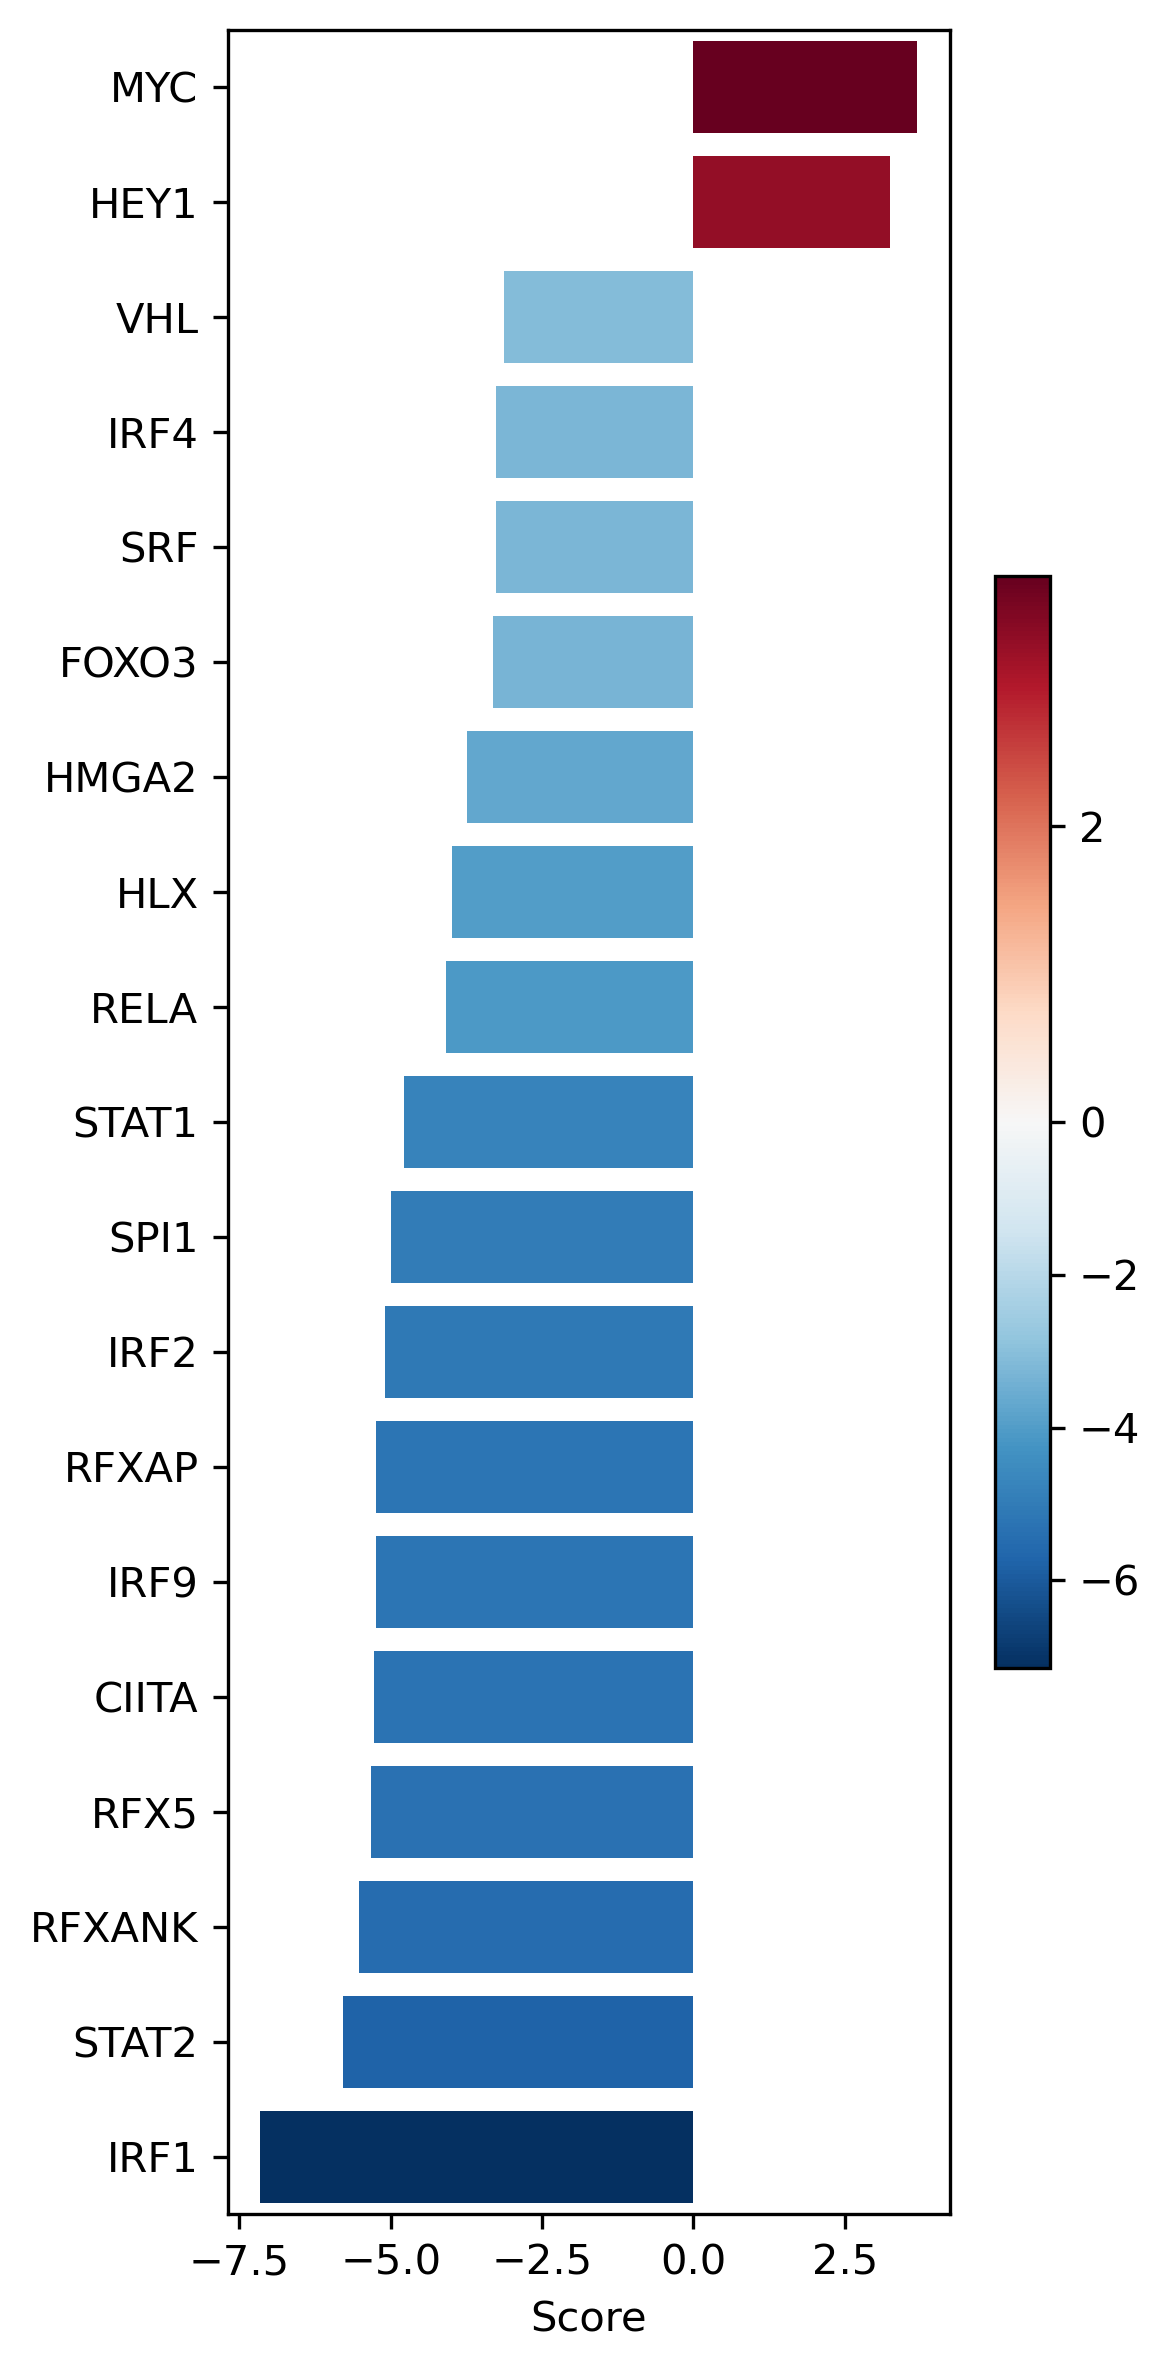

In [132]:
dc.pl.barplot(
    data=tf_acts,
    name='non_survival.vs.icu',
    top = 30,
    figsize=(4, 8), save = "../plots/top_TFs_nonclassical_non_survival_vs_icu.png", dpi = 300
)

In [133]:
tf_series = tf_acts.T.iloc[:, 0]  # Convert to Series (1 column DataFrame → Series)

# Sort by activity
top10 = tf_series.sort_values(ascending=False).head(10).index.tolist()
bottom10 = tf_series.sort_values(ascending=True).head(10).index.tolist()

#top 20 regardless od direction
top20 = tf_series.abs().sort_values(ascending=False).head(20).index.tolist()

selected_genes = top10 + bottom10
# Display
print("Top 10 TFs:")
print(top10)

print("\nBottom 10 TFs:")
print(bottom10)

Top 10 TFs:
['MYC', 'HEY1', 'VHL', 'IRF4', 'SRF', 'FOXO3', 'HMGA2', 'HLX', 'RELA', 'STAT1']

Bottom 10 TFs:
['IRF1', 'STAT2', 'RFXANK', 'RFX5', 'CIITA', 'IRF9', 'RFXAP', 'IRF2', 'SPI1', 'STAT1']


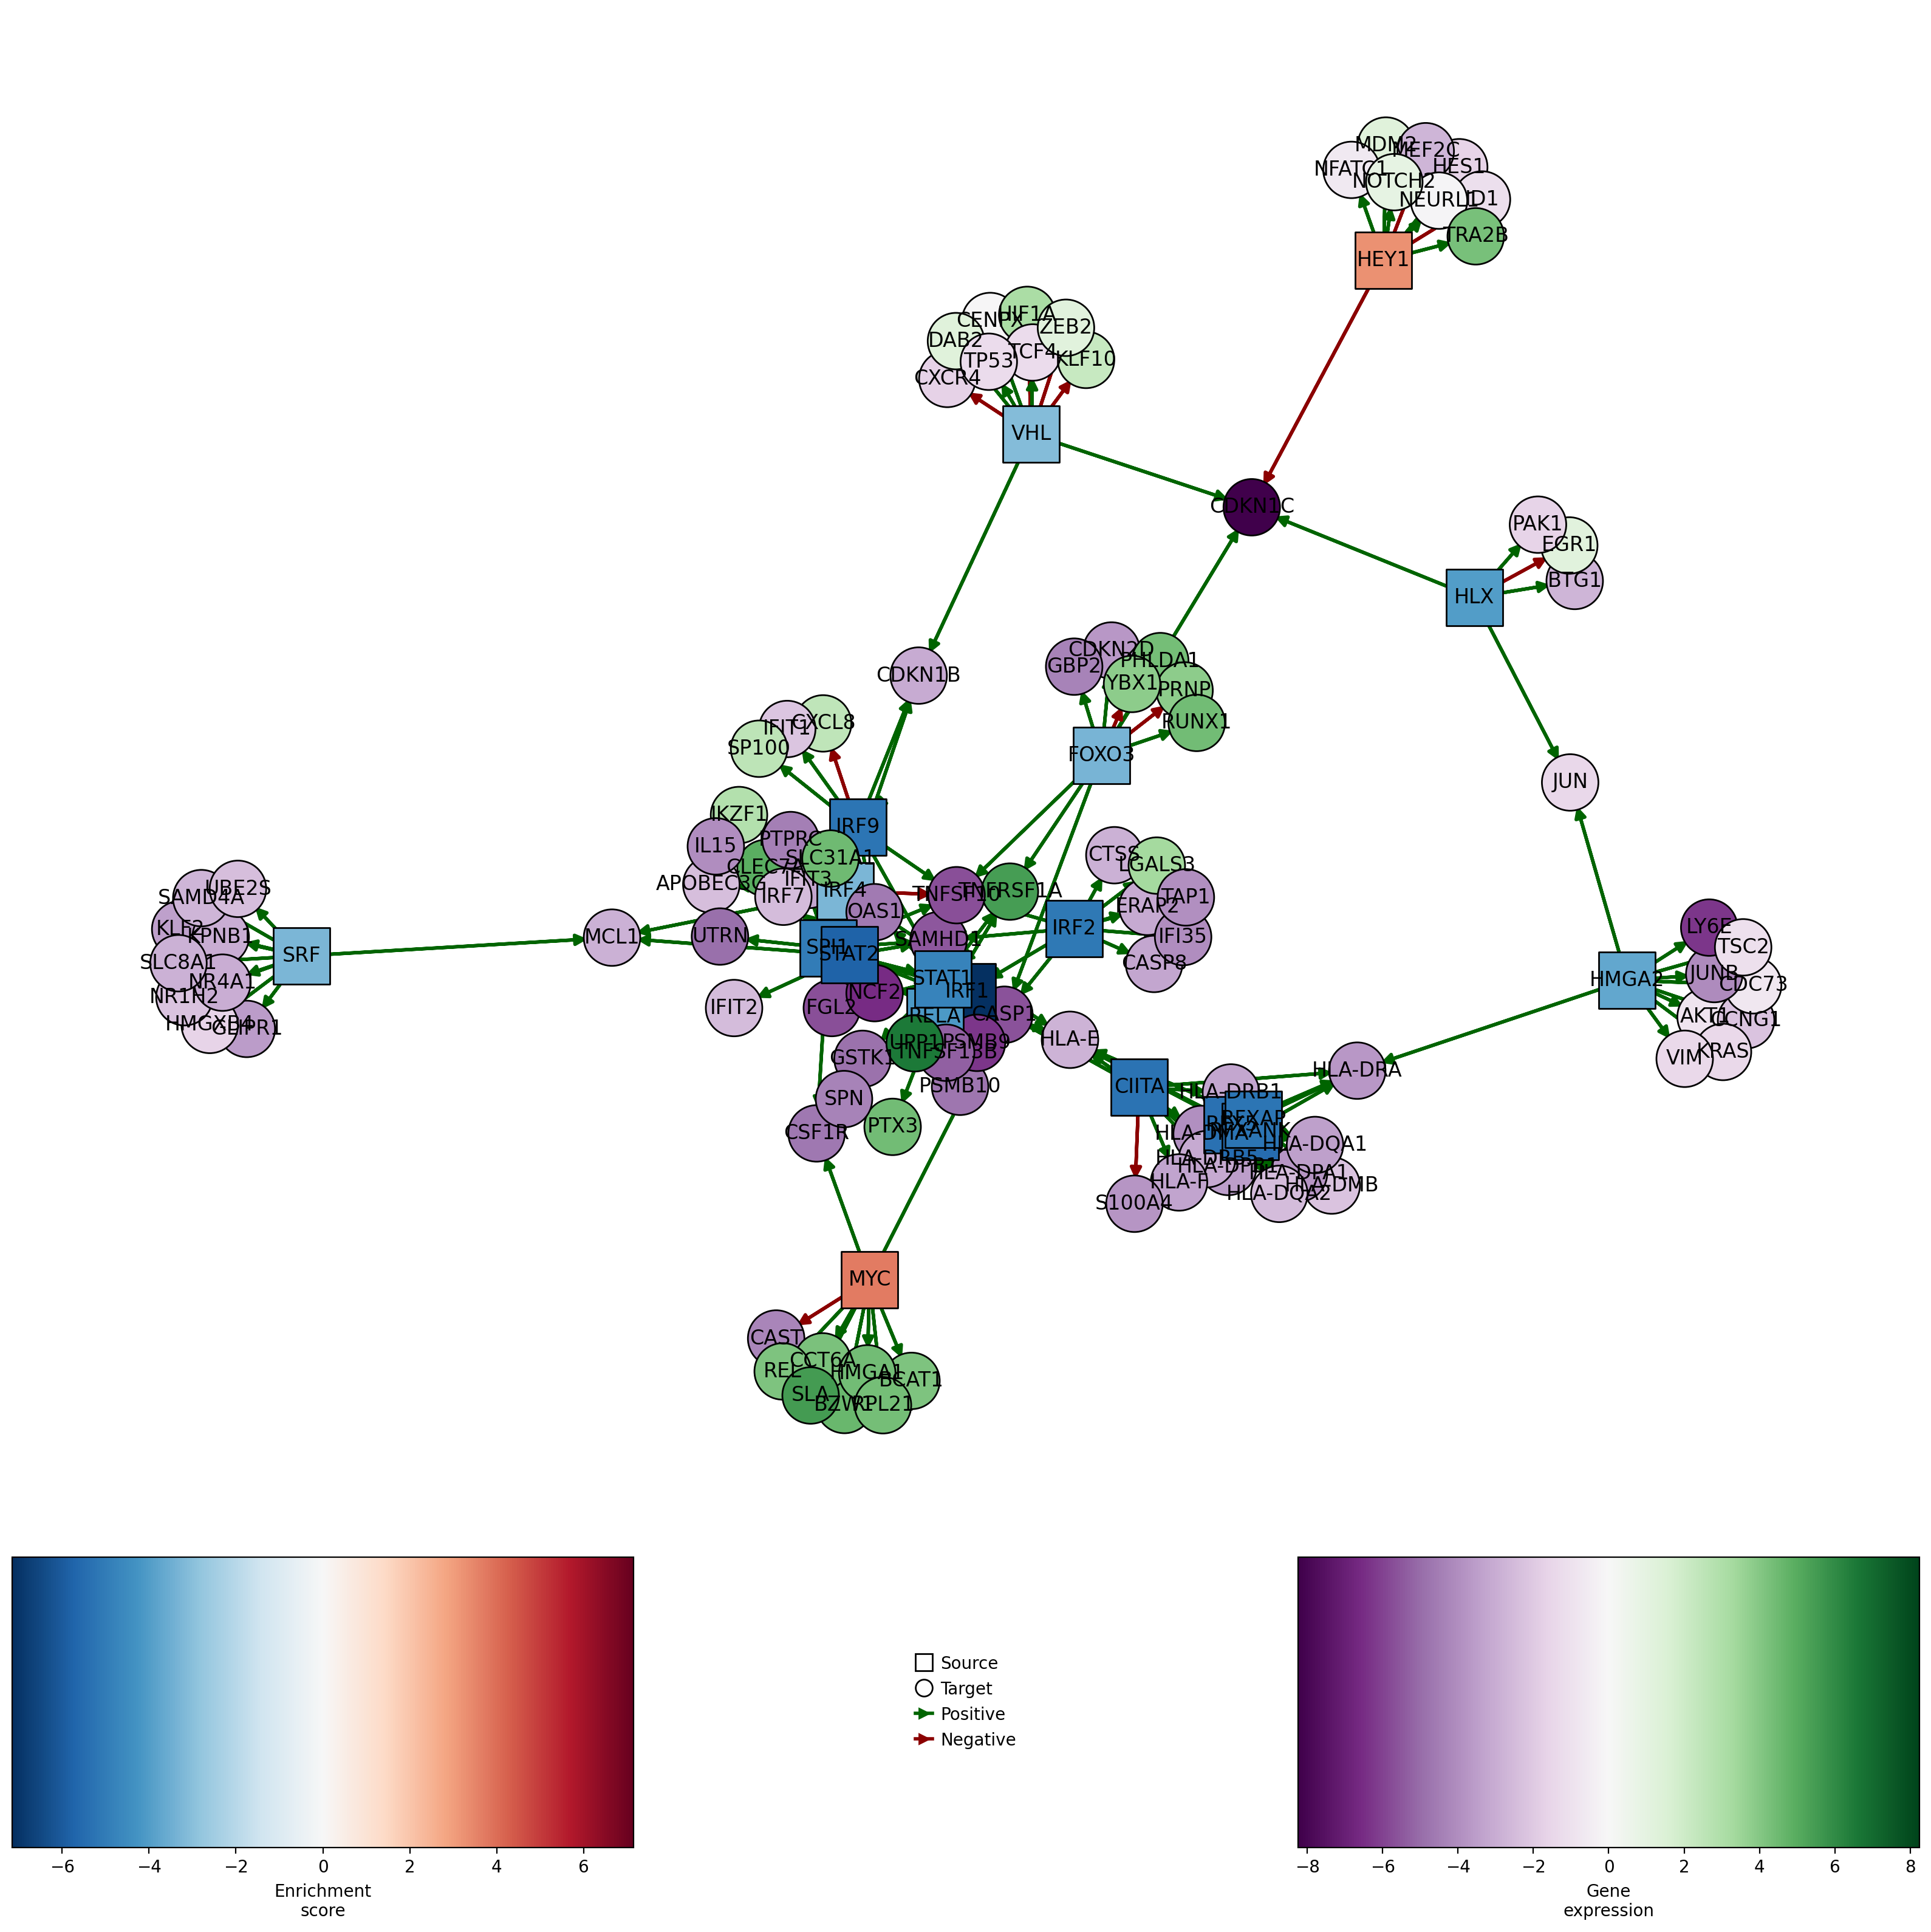

In [134]:
dc.pl.network(
    net=collectri,
    data=data_clean,
    score=tf_acts,
    sources=selected_genes,
    targets=10,
    vcenter=True,
    by_abs=True,
    size_node=120,
    t_cmap="PRGn",
    layout = "fr",
    figsize=(16,16), save = "../plots/network_nonclassical_non_survival_vs_icu.png", dpi = 200
)